In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Notebook display options
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import dframe_tools as dtools
import plot_tools as ptools
import gen_resubmit as gensub

# Comment out for description of below modules
# dtools.help()
# ptools.help()
# gensub.help()

### If you import data from csv, put 1 here
is_csv = 1


#=========================================================================
if is_csv == 1:

    dbase = pd.read_csv('../data/vacuum_data.csv')

else:
### from raw data
    path = '/home/sang/UVM/He4vacuum/OUTPUT'
    dbase = dtools.df_pimc(path, skip = 0, noenergy = 1, replace = 1)

dfdict = ptools.datadic(dbase)

plot style is loaded
dict_keys(['0.23,-89.8', '0.23,-89.1', '0.23,-90.3', '0.23,-89.5', '0.07,-110.0', '0.07,-111.0', '0.07,-112.0', '0.05,-117.0', '0.05,-116.0', '0.26,-86.8', '0.26,-88.0', '0.26,-85.6', '0.26,-85.0', '0.26,-86.0', '0.26,-87.0', '0.26,-86.3', '0.25,-86.8', '0.25,-87.6', '0.25,-88.0', '0.25,-87.2', '0.08,-111.0', '0.08,-109.0', '0.08,-108.0', '0.08,-112.0', '0.08,-113.0', '0.08,-114.0', '0.02,-123.0', '0.02,-124.0', '0.02,-125.0', '0.02,-126.0', '0.16,-100.0', '0.16,-95.5', '0.16,-99.0', '0.16,-95.8', '0.16,-97.0', '0.16,-95.1', '0.16,-98.0', '0.16,-96.3', '0.24,-88.0', '0.24,-90.0', '0.24,-89.0', '0.24,-87.0', '0.24,-88.8', '0.24,-88.4', '0.24,-89.2', '0.0,-128.0', '0.0,-127.0', '0.0,-129.0', '0.0,-130.0', '0.22,-90.0', '0.22,-89.0', '0.22,-90.3', '0.22,-91.0', '0.22,-91.5', '0.22,-92.0', '0.22,-90.7', '0.22,-91.1', '0.11,-106.0', '0.11,-105.0', '0.12,-106.0', '0.12,-105.0', '0.12,-104.0', '0.12,-108.0', '0.12,-107.0', '0.27,-84.8', '0.27,-84.0', '0.27,-84.3', '0.27,-

In [2]:
def keysorting(k):
    t = k.split(',')
    n = float(t[0])*100000 + float(t[1])
    return n

keylst = []
for keys in dfdict.keys():
    keylst.append(keys)
keylst = sorted(keylst, key = lambda k: keysorting(k))
print(keysorting(keylst[0]))
print(keylst)
print('number of category:', len(keylst))
for keys in keylst:
    print(ptools.nparallel( dfdict[keys] ), end=' ')

-130.0
['0.0,-130.0', '0.0,-129.0', '0.0,-128.0', '0.0,-127.0', '0.01,-126.0', '0.01,-125.0', '0.02,-126.0', '0.02,-125.0', '0.02,-124.0', '0.02,-123.0', '0.03,-122.0', '0.03,-121.0', '0.04,-122.0', '0.04,-121.0', '0.04,-120.0', '0.04,-119.0', '0.05,-117.0', '0.05,-116.0', '0.06,-118.0', '0.06,-117.0', '0.06,-116.0', '0.06,-115.0', '0.06,-114.0', '0.06,-113.0', '0.07,-112.0', '0.07,-111.0', '0.07,-110.0', '0.08,-114.0', '0.08,-113.0', '0.08,-112.0', '0.08,-111.0', '0.08,-109.0', '0.08,-108.0', '0.09,-109.0', '0.09,-108.0', '0.09,-107.0', '0.1,-112.0', '0.1,-111.0', '0.1,-110.0', '0.1,-109.0', '0.1,-108.0', '0.1,-107.0', '0.11,-106.0', '0.11,-105.0', '0.12,-108.0', '0.12,-107.0', '0.12,-106.0', '0.12,-105.0', '0.12,-104.0', '0.13,-102.0', '0.13,-101.0', '0.14,-104.0', '0.14,-103.0', '0.14,-102.0', '0.14,-101.0', '0.14,-100.0', '0.14,-99.8', '0.14,-99.4', '0.14,-99.0', '0.15,-98.3', '0.15,-97.8', '0.15,-97.5', '0.15,-97.1', '0.16,-100.0', '0.16,-99.0', '0.16,-98.0', '0.16,-97.0', '0.16,-

In [3]:
# Find mu for simulations with 'relaxmu' option
if is_csv != 1:
    realmu = []
    for i in range(len(dbase)):
        file_path = subset.iloc[i]['filedic']['log']
        ref = file_path.find('log')
        realmu.append(float(file_path[ref+19:ref+27]))

    dbase['realmu'] = realmu

In [4]:
### Export data
# dbase.to_csv('../data/vacuum_data.csv',index=False)

In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression
def sort_list(list1, list2):
 
    zipped_pairs = zip(list2, list1)
 
    z = [x for _, x in sorted(zipped_pairs)]
     
    return z

def linear_fit(subset):
    mu = []
    muave = []
    n = []
    nave = []
    nerr = []
    for i in range(len(subset)):
        if subset.iloc[i]['n'] < 0.9 and subset.iloc[i]['n'] > 0.01:
            lid = subset.iloc[i]['id']
            muave.append(subset.iloc[i]['realmu'])
            nave.append(subset.iloc[i]['n'])
            nerr.append(subset.iloc[i]['nerr'])
        elif subset.iloc[i]['n'] < 4 and subset.iloc[i]['n'] >= 0.9:
            lid = subset.iloc[i]['id']
            mu.append(subset.iloc[i]['realmu'])
            n.append(subset.iloc[i]['n'])
            nerr.append(subset.iloc[i]['nerr'])
    if len(muave)>0:
        mu.append(sum(muave)/len(muave))
        n.append(sum(nave)/len(nave))
    
#     a1,a1_err = get_a(mu,n,nerr)
#     print(a1)
    n = sort_list(n,mu)
    mu = sorted(mu)
    
    mu = np.array(mu)
    n = np.array(n)
    
    if len(mu) >= 2:

        reg = LinearRegression().fit(mu.reshape((-1, 1)), n)
        # print(reg.score(x, y))
        
#         print(reg.coef_)
#         print(reg.intercept_)

        fx = np.linspace(min(mu)*1.1,max(mu)*0.9,20)
    #     plt.plot(fx,a1[0]+a1[1]*fx, label = 'a method')
        plt.scatter(mu, n)
        plt.plot(fx,reg.intercept_+reg.coef_*fx, label = 'Reg method')
#         print(-reg.intercept_/reg.coef_)
        return -reg.intercept_/reg.coef_[0], nerr
    else:
        return mu[0], nerr

0.0, 16, -128.57171035348006 0.04854413977223248
0.0, 64, -128.41913381977633 0.08332297096541426
0.01, 16, -126.19999999999999 0.003341508487751773
0.01, 64, -126.19999999999999 0.008218710739804487
0.02, 16, -122.57441581264328 0.05275225831185749
0.02, 64, -123.52728571428572 0.013173207401967105
0.03, 16, -122.2 0.003580470178700447
0.03, 64, -121.93333333333332 0.012590555125450256
0.04, 16, -117.24825 0.022609117963191958
0.04, 64, -120.28033333333333 0.014878340341922569
0.05, 16, -117.1 0.008054819199413681
0.05, 64, -117.10000000000001 0.018065687118061585
0.06, 16, -113.58620357774191 0.05074880311945533
0.06, 64, -114.124 0.031248616252217438
0.07, 16, -111.39999999999999 0.036659018689044885
0.07, 64, -111.96550812260824 0.05677581359793056
0.08, 16, -109.6067995183119 0.059619356731865226
0.08, 64, -109.99695610595015 0.061603044549587586
0.09, 16, -108.4 0.016714649051680342
0.09, 64, -108.39999999999999 0.03536256066476804
0.1, 16, -107.86783231631634 0.04862560351766719

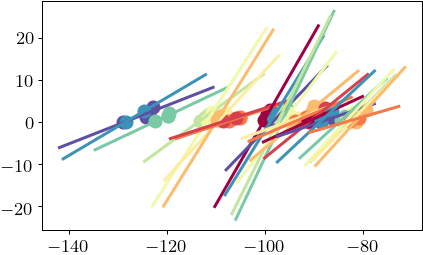

In [6]:
# New result
# This print strain, total adsorption sites, real chemical potential, maximum error
vacuums = {}
for s in range(31):
    for totN in (16,64):
        strain = 0.0 + 0.01*s

        lab = f'{strain}, {totN}'
        subset = dbase[(dbase['strain'] == strain)&(dbase['totN'] == totN)]

        intercept, nerr = linear_fit(subset)

        print(lab+',', intercept, max(nerr))
        vacuums[lab] = intercept

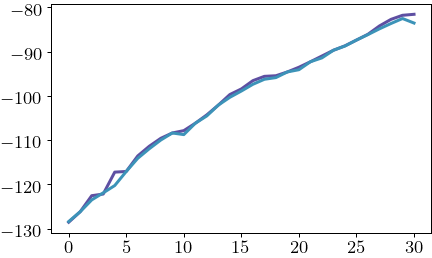

In [7]:
# Rough data
plotx1 = []
ploty1 = []
for s in range(31):
    for totN in (16,):
        strain = 0.0 + 0.01*s
        lab = f'{strain}, {totN}'
        plotx1.append(strain*100)
        ploty1.append(vacuums[lab])
plotx2 = []
ploty2 = []
for s in range(31):
    for totN in (64,):
        strain = 0.0 + 0.01*s
        lab = f'{strain}, {totN}'
        plotx2.append(strain*100)
        ploty2.append(vacuums[lab])
plt.plot(plotx1, ploty1)
plt.plot(plotx2, ploty2)
plt.show()

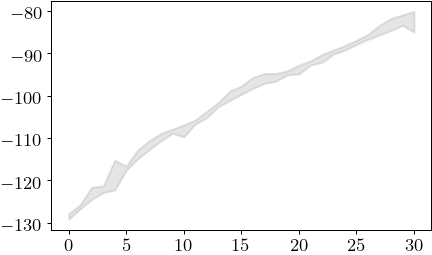

In [8]:
plotx = np.array(plotx1)
ploty = np.array(ploty1)+np.array(ploty2)
ploty = ploty/2
plotydiff = np.array(ploty1) - np.array(ploty2)
plotydiff = np.sqrt(plotydiff*plotydiff)

plt.fill_between(plotx, ploty - plotydiff -0.5, ploty + plotydiff +0.5,
                 color='gray', alpha=0.2)

0.4896849700316624 1.364617619425688


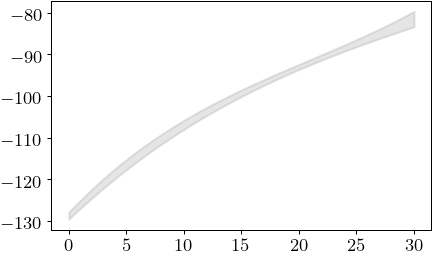

In [9]:
# UnivariateSpline Curve
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from scipy.interpolate import UnivariateSpline
new_x = np.linspace(0,30,100)
f1 = UnivariateSpline(plotx, ploty,)
f2 = UnivariateSpline(plotx, plotydiff,)

dev = sum(f2(new_x))/len(f2(new_x))
print(dev, max(f2(new_x)))
plt.fill_between(new_x, f1(new_x) - f2(new_x) -0.5, f1(new_x) + f2(new_x) +0.5,
                 color='gray', alpha=0.2)

In [11]:
# Export data
np.savetxt("../data/vacuumline_x.csv", new_x, delimiter =", ", fmt='%.12f')
np.savetxt("../data/vacuumline_yd.csv", f1(new_x) - f2(new_x), delimiter =", ", fmt='%.12f')
np.savetxt("../data/vacuumline_yu.csv", f1(new_x) + f2(new_x), delimiter =", ", fmt='%.12f')